# CatBoost Hyperparameter Tuning for Fraud Detection

This notebook performs grid search hyperparameter tuning for the CatBoost model using the `CatBoostGridSearchTuner` class.

## Objectives
1. Define parameter grid for tuning
2. Train multiple CatBoost configurations
3. Compare performance across hyperparameters
4. Identify best configuration
5. Compare best CatBoost against baseline models

## Hyperparameters to Tune
- **Learning Rate**: Gradient boosting step size
- **Depth**: Tree depth
- **L2 Leaf Regularization**: Overfitting control
- **Iterations**: Number of trees


In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('../..'))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

from src.catboost_models import CatBoostGridSearchTuner

import warnings
warnings.filterwarnings('ignore')

print("Environment ready for CatBoost hyperparameter tuning.")


Environment ready for CatBoost hyperparameter tuning.


## 1. Define Base Configuration and Parameter Grid


In [2]:
# Base configuration (parameters that won't change)
base_config = {
    # Data
    'data_path': '../../data/processed/creditcard_fe.csv',
    'drop_features': 'logreg_baseline',
    
    # Fixed training parameters
    'l2_leaf_reg': 3.0,  # Default regularization
    
    # Business costs
    'C_FP': 550,  # False positive cost (investigation)
    'C_FN': 110,  # False negative cost (missed fraud)
    
    # Hardware
    'random_seed': 42,
    
    # Save directories
    'model_save_dir': '../../models/',
}

# Parameter grid to search
param_grid = {
    'learning_rate': [0.1, 0.05, 0.02],   # Gradient step size
    'depth': [4, 6, 8],                    # Tree depth
    'l2_leaf_reg': [1.0, 3.0, 5.0],       # Regularization
    'iterations': [200, 400]              # Number of trees
}

# Calculate total configurations
total_configs = np.prod([len(v) for v in param_grid.values()])

print("Hyperparameter Tuning Configuration")
print("=" * 60)
print(f"\nBase Configuration:")
for key, value in base_config.items():
    print(f"  {key:20s}: {value}")

print(f"\nParameter Grid:")
for key, values in param_grid.items():
    print(f"  {key:20s}: {values}")

print(f"\nTotal Configurations: {total_configs}")
print(f"Estimated Time (1 min/config): ~{total_configs} minutes")


Hyperparameter Tuning Configuration

Base Configuration:
  data_path           : ../../data/processed/creditcard_fe.csv
  drop_features       : logreg_baseline
  l2_leaf_reg         : 3.0
  C_FP                : 550
  C_FN                : 110
  random_seed         : 42
  model_save_dir      : ../../models/

Parameter Grid:
  learning_rate       : [0.1, 0.05, 0.02]
  depth               : [4, 6, 8]
  l2_leaf_reg         : [1.0, 3.0, 5.0]
  iterations          : [200, 400]

Total Configurations: 54
Estimated Time (1 min/config): ~54 minutes


## 2. Run Grid Search

This will train all configurations and track results. The best model (by validation cost) will be automatically saved.


In [4]:
results_csv_path = '../../results/tuning/catboost_grid_search_results.csv'

if os.path.exists(results_csv_path):
    print("=" * 70)
    print("LOADING PRE-COMPUTED GRID SEARCH RESULTS")
    print("=" * 70)
    
    results_df = pd.read_csv(results_csv_path)

    # Backward compatibility: older CSVs may not have 'config_idx'
    if 'config_idx' not in results_df.columns:
        results_df = results_df.reset_index().rename(columns={'index': 'config_idx'})
    
    print(f"\n✓ Successfully loaded {len(results_df)} configurations")
    print(f"✓ Best validation cost: ${results_df['val_cost'].min():,.0f}")
    print(f"✓ Best test cost: ${results_df['test_cost'].min():,.0f}")
    
    # Show best configuration
    best_idx = results_df['val_cost'].idxmin()
    best_config = results_df.loc[best_idx]
    
    print(f"\n{'='*70}")
    print("BEST CONFIGURATION (by validation cost):")
    print(f"{'='*70}")
    print(f"  Config Index:     {int(best_config['config_idx'])}")
    print(f"  Learning Rate:    {best_config['learning_rate']}")
    print(f"  Depth:           {int(best_config['depth'])}")
    print(f"  L2 Leaf Reg:     {best_config['l2_leaf_reg']}")
    print(f"  Iterations:       {int(best_config['iterations'])}")
    print(f"\n  Validation Cost:  ${int(best_config['val_cost']):,}")
    print(f"  Test Cost:        ${int(best_config['test_cost']):,}")
    print(f"  Precision:        {best_config['test_precision']:.3f}")
    print(f"  Recall:           {best_config['test_recall']:.3f}")
    print(f"  PR-AUC:           {best_config['test_pr_auc']:.4f}")
    
    print(f"\n{'='*70}")
    print("✓ Ready to analyze! Skip to Section 3 (Analyze Tuning Results)")
    print(f"{'='*70}")
else:
    print(f"Results not found at: {results_csv_path}")
    print("Please run the grid search cell below to generate results.")


LOADING PRE-COMPUTED GRID SEARCH RESULTS

✓ Successfully loaded 54 configurations
✓ Best validation cost: $3,740
✓ Best test cost: $2,200

BEST CONFIGURATION (by validation cost):
  Config Index:     25
  Learning Rate:    0.05
  Depth:           6
  L2 Leaf Reg:     1.0
  Iterations:       200

  Validation Cost:  $3,740
  Test Cost:        $2,310
  Precision:        1.000
  Recall:           0.788
  PR-AUC:           0.8781

✓ Ready to analyze! Skip to Section 3 (Analyze Tuning Results)


### Option A: Run Full Grid Search


In [ ]:
# Uncomment to run full grid search
# tuner = CatBoostGridSearchTuner(
#     base_config=base_config,
#     param_grid=param_grid,
#     results_dir='../../results/tuning/'
# )
#
# results_df = tuner.run_grid_search()


CATBOOST HYPERPARAMETER TUNING - GRID SEARCH

[1/4] Grid Search Configuration:
  Total configurations: 54
  Parameters:
    learning_rate: [0.1, 0.05, 0.02]
    depth: [4, 6, 8]
    l2_leaf_reg: [1.0, 3.0, 5.0]
    iterations: [200, 400]

[2/4] Running grid search...
----------------------------------------------------------------------

Config 1/54: lr=0.1, depth=4, l2=1.0, iter=200

[1/6] Loading and preparing data...
Loading data from ../../data/processed/creditcard_fe.csv...
Dataset loaded: 284807 transactions
  Normal: 284315 (99.83%)
  Fraud: 492 (0.17%)
  Features: 22
  Dropped features: 14

Data split:
  Training: 170884 transactions
  Validation: 56961 transactions (98 fraud)
  Test: 56962 transactions (99 fraud)

[2/6] Scaling features...
Features scaled using StandardScaler

[3/6] Building CatBoost model...
  Learning rate: 0.1
  Depth: 4
  Iterations: 200

Training CatBoost model...
Training completed!
  Best iteration: 196
  Best validation Logloss: 0.0030

[4/6] Finding o

## 3. Analyze Tuning Results


In [5]:
# Display top 10 configurations by test cost
print("\n" + "="*70)
print("TOP 10 CONFIGURATIONS BY TEST COST")
print("="*70)

top10 = results_df.nsmallest(10, 'test_cost')[[
    'config_idx', 'learning_rate', 'depth', 'l2_leaf_reg', 'iterations',
    'test_cost', 'test_precision', 'test_recall', 'test_pr_auc'
]].copy()

# Format for display
top10['test_cost'] = top10['test_cost'].apply(lambda x: f"${int(x):,}")
top10['test_precision'] = top10['test_precision'].apply(lambda x: f"{x:.3f}")
top10['test_recall'] = top10['test_recall'].apply(lambda x: f"{x:.3f}")
top10['test_pr_auc'] = top10['test_pr_auc'].apply(lambda x: f"{x:.4f}")

print(top10.to_string(index=False))



TOP 10 CONFIGURATIONS BY TEST COST
 config_idx  learning_rate  depth  l2_leaf_reg  iterations test_cost test_precision test_recall test_pr_auc
          2           0.10      4          1.0         400    $2,200          1.000       0.798      0.8710
         25           0.05      6          1.0         200    $2,310          1.000       0.788      0.8781
         44           0.02      6          1.0         400    $2,310          1.000       0.788      0.8755
          1           0.10      4          1.0         200    $2,420          1.000       0.778      0.8701
          7           0.10      6          1.0         200    $2,420          1.000       0.778      0.8759
          8           0.10      6          1.0         400    $2,420          1.000       0.778      0.8759
         26           0.05      6          1.0         400    $2,420          1.000       0.778      0.8783
         34           0.05      8          3.0         400    $2,420          1.000       0.778     

In [6]:
# Summary statistics
print("\n" + "="*70)
print("TUNING SUMMARY STATISTICS")
print("="*70)

print(f"\nTest Cost:")
print(f"  Best: ${results_df['test_cost'].min():,.0f}")
print(f"  Worst: ${results_df['test_cost'].max():,.0f}")
print(f"  Mean: ${results_df['test_cost'].mean():,.0f}")
print(f"  Std Dev: ${results_df['test_cost'].std():,.0f}")

print(f"\nPrecision:")
print(f"  Best: {results_df['test_precision'].max():.3f}")
print(f"  Worst: {results_df['test_precision'].min():.3f}")
print(f"  Mean: {results_df['test_precision'].mean():.3f}")

print(f"\nRecall:")
print(f"  Best: {results_df['test_recall'].max():.3f}")
print(f"  Worst: {results_df['test_recall'].min():.3f}")
print(f"  Mean: {results_df['test_recall'].mean():.3f}")

print(f"\nPR-AUC:")
print(f"  Best: {results_df['test_pr_auc'].max():.4f}")
print(f"  Worst: {results_df['test_pr_auc'].min():.4f}")
print(f"  Mean: {results_df['test_pr_auc'].mean():.4f}")



TUNING SUMMARY STATISTICS

Test Cost:
  Best: $2,200
  Worst: $4,950
  Mean: $3,029
  Std Dev: $570

Precision:
  Best: 1.000
  Worst: 0.940
  Mean: 0.995

Recall:
  Best: 0.798
  Worst: 0.596
  Mean: 0.740

PR-AUC:
  Best: 0.8794
  Worst: 0.8569
  Mean: 0.8716


## 4. Impact of Individual Hyperparameters


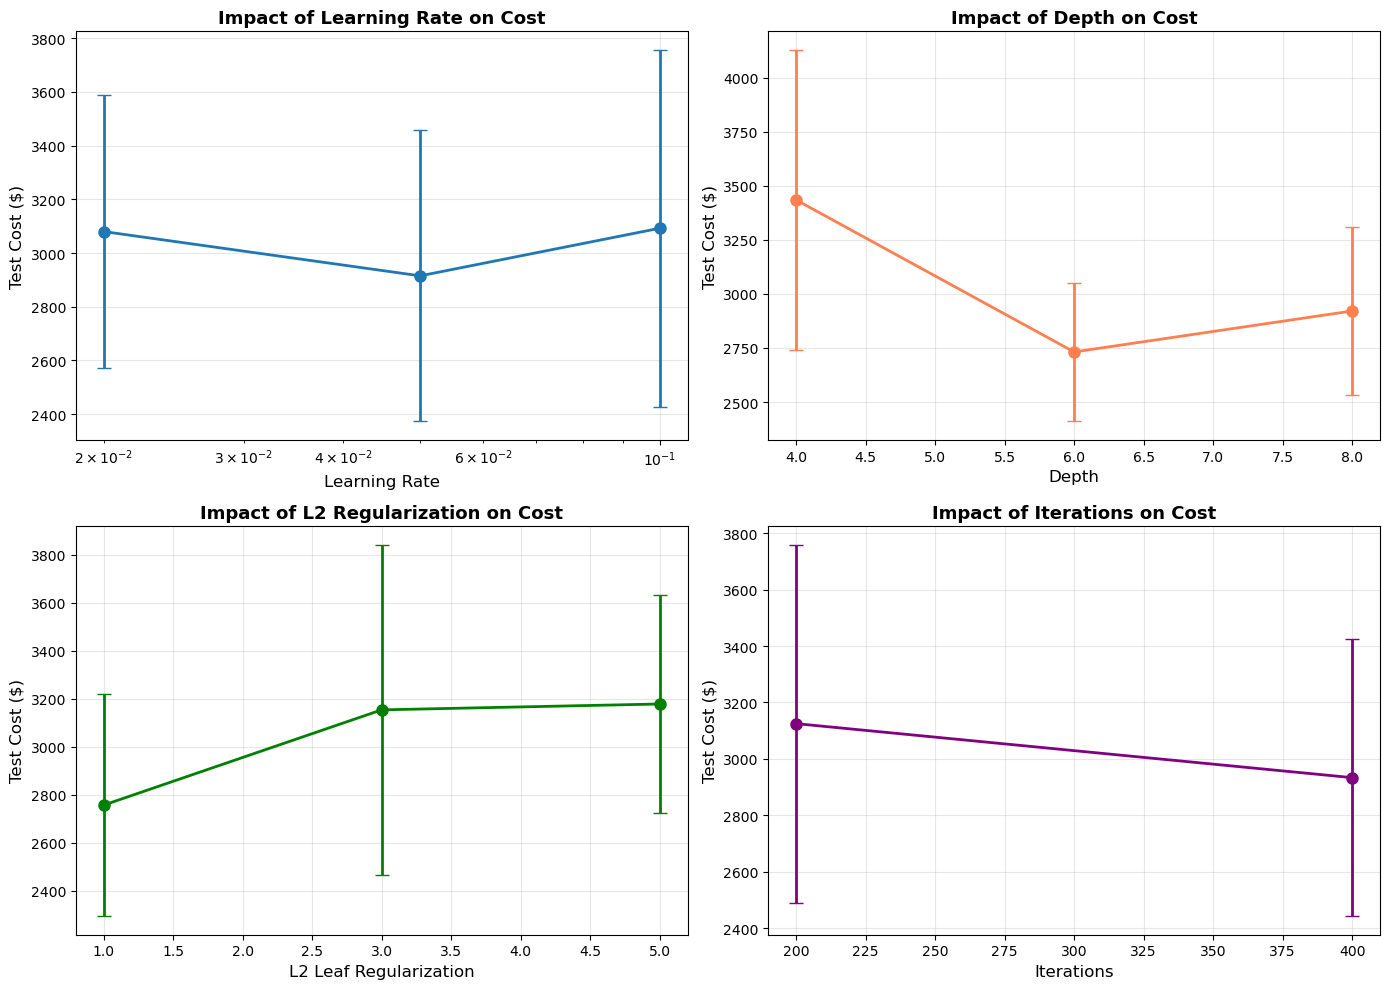


Hyperparameter impact plot saved: results/figures/catboost_hyperparameter_impact_analysis.png


In [7]:
# Analyze impact of each hyperparameter on test cost
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Learning Rate
ax = axes[0, 0]
grouped = results_df.groupby('learning_rate')['test_cost'].agg(['mean', 'std', 'min', 'max'])
ax.errorbar(grouped.index, grouped['mean'], yerr=grouped['std'], 
            marker='o', capsize=5, linewidth=2, markersize=8)
ax.set_xlabel('Learning Rate', fontsize=12)
ax.set_ylabel('Test Cost ($)', fontsize=12)
ax.set_title('Impact of Learning Rate on Cost', fontsize=13, fontweight='bold')
ax.set_xscale('log')
ax.grid(True, alpha=0.3)

# 2. Depth
ax = axes[0, 1]
grouped = results_df.groupby('depth')['test_cost'].agg(['mean', 'std', 'min', 'max'])
ax.errorbar(grouped.index, grouped['mean'], yerr=grouped['std'], 
            marker='o', capsize=5, linewidth=2, markersize=8, color='coral')
ax.set_xlabel('Depth', fontsize=12)
ax.set_ylabel('Test Cost ($)', fontsize=12)
ax.set_title('Impact of Depth on Cost', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)

# 3. L2 Leaf Regularization
ax = axes[1, 0]
grouped = results_df.groupby('l2_leaf_reg')['test_cost'].agg(['mean', 'std', 'min', 'max'])
ax.errorbar(grouped.index, grouped['mean'], yerr=grouped['std'], 
            marker='o', capsize=5, linewidth=2, markersize=8, color='green')
ax.set_xlabel('L2 Leaf Regularization', fontsize=12)
ax.set_ylabel('Test Cost ($)', fontsize=12)
ax.set_title('Impact of L2 Regularization on Cost', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)

# 4. Iterations
ax = axes[1, 1]
grouped = results_df.groupby('iterations')['test_cost'].agg(['mean', 'std', 'min', 'max'])
ax.errorbar(grouped.index, grouped['mean'], yerr=grouped['std'], 
            marker='o', capsize=5, linewidth=2, markersize=8, color='purple')
ax.set_xlabel('Iterations', fontsize=12)
ax.set_ylabel('Test Cost ($)', fontsize=12)
ax.set_title('Impact of Iterations on Cost', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../../results/figures/catboost_hyperparameter_impact_analysis.png', 
            dpi=300, bbox_inches='tight')
plt.show()

print("\nHyperparameter impact plot saved: results/figures/catboost_hyperparameter_impact_analysis.png")
